In [60]:
import json
import random
import matplotlib.pyplot as plt

In [3]:

with open('../dataset/layers/layer3.json') as dataset_file:
    dataset = json.load(dataset_file)

In [4]:
print(dataset[0])

{'valid': [True, True, True, True, True, True, True, True, False, False, True, True, True, False], 'id': '000018c8a5', 'ingredients': [{'text': 'penne'}, {'text': 'cheese sauce'}, {'text': 'cheddar cheese'}, {'text': 'gruyere cheese'}, {'text': 'dried chipotle powder'}, {'text': 'unsalted butter'}, {'text': 'all - purpose flour'}, {'text': 'milk'}, {'text': '14 ounces semihard cheese (page 23), grated (about 3 1/2 cups)'}, {'text': '2 ounces semisoft cheese (page 23), grated (1/2 cup)'}, {'text': 'kosher salt'}, {'text': 'dried chipotle powder'}, {'text': 'garlic powder'}, {'text': '(makes about 4 cups)'}]}


In [5]:
def get_random_shuffles(list_to_shuffle, var_num=10):
    ret_list = []
    for i in range(var_num):
        random.shuffle(list_to_shuffle)
        ret_list.append(list_to_shuffle[:])
    return ret_list

In [116]:
ingredient_list = []
for recipe in dataset:
    valid_ingredients = []
    for i in range(len(recipe["ingredients"])):
        if recipe["valid"][i]:
            valid_ingredients.append(recipe["ingredients"][i]["text"])
    ingredient_list.append(["".join(ing.split()) for ing in valid_ingredients])

In [197]:
print(ingredient_list[1000])
print(ingredient_list[100000])
print(ingredient_list[5000])


['watermelon', 'Splendasugarsubstitute', 'lemons', 'lime-flavoredseltzerwater']
['freshgarliccloves', 'koshersalt', 'blackpepper', 'spaghettinoodles', 'driedbasil', 'butter', 'eggs', 'mozzarellacheese', 'tomatosauce', 'lightoliveoil', 'chickenbreasthalves', 'parmesancheese']
['peanutbutter', 'rice', 'ginger', 'honey', 'lemon', 'chickentenderloins', 'chilipaste']


In [117]:
# remove outliers
# removes all ingredients that occur less than MINIMUM_OCCURENCES times
from collections import defaultdict

MINIMUM_OCCURENCES = 2

vocab_count = defaultdict(int)
for ingredients in ingredient_list:
    for ingredient in ingredients:
        vocab_count[ingredient] += 1
        
counter = 0
for v in vocab_count.values():
    if v < MINIMUM_OCCURENCES:
        counter += 1

for i in range(len(ingredient_list)):
    new_ingredients = []
    for ingredient in ingredient_list[i]:
        if vocab_count[ingredient] > 1:
            new_ingredients.append(ingredient)
    ingredient_list[i] = new_ingredients


print('removed', counter, 'outliers')
    

removed 2755 outliers


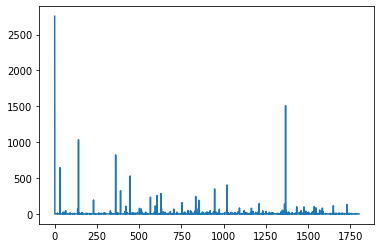

In [120]:

counter_counter = defaultdict(int)
for v in vocab_count.values():
    counter_counter[v] += 1
plt.plot(counter_counter.values())

In [121]:
# data augmentation
# multiply dataset with random shuffles for word2vec
# based on the assumption that the order of ingredients in a recipe is not important

augmented_list = []
for ingredients in ingredient_list:
    for ing_list in get_random_shuffles(ingredients):
        augmented_list.append(ing_list)
ingredient_list = augmented_list

In [122]:
from gensim.models import Word2Vec
ingredients_per_recipe = ingredient_list
model = Word2Vec(sentences=ingredients_per_recipe, size=100, window=3, min_count=1, workers=4)

In [9]:
print(model.wv.most_similar('potato', topn=50))

[('potatoes', 0.8750154376029968), ('turnip', 0.6734368801116943), ('whitepotato', 0.652134120464325), ('bakingpotato', 0.6355170011520386), ('whitepotatoes', 0.6341703534126282), ('dumplings', 0.6308233737945557), ('leek', 0.6186506748199463), ('parsnip', 0.613868236541748), ('greenpeas', 0.6040278077125549), ('boiledpotatoes', 0.6038579940795898), ('newpotato', 0.6027263402938843), ('rawpotatoes', 0.5932386517524719), ('redpotatoes', 0.5928860902786255), ('russetpotato', 0.5923498868942261), ('parsleyroot', 0.590911865234375), ('peas', 0.5905178785324097), ('bouillon', 0.5897656083106995), ('newpotatoes', 0.5879443883895874), ('bouilloncube', 0.5847479701042175), ('soupbones', 0.5759333372116089), ('potbarley', 0.5753577947616577), ('boilingpotatoes', 0.5687046051025391), ('stock', 0.5679877996444702), ('bayleaf', 0.5637009143829346), ('splitpeas', 0.5618088245391846), ('smallpotatoes', 0.5526571273803711), ('yellowsplitpeas', 0.5435934066772461), ('swede', 0.5433222651481628), ('cel

In [10]:
import difflib


In [208]:
# finding ingredients that are practically the same (potato == redpotato)
# building a graph of same ingredients
graph = {}

for ingredient in model.wv.vocab.keys():
    edges = []
    for result in model.wv.most_similar(ingredient, topn=50):
        similarity = difflib.SequenceMatcher(None, ingredient, result[0]).ratio()
        if similarity > 0.75 and result[1] > 0.6:
            edges.append(result[0])
    graph[ingredient] = (edges, False, None) # edges, visited, component



In [299]:
#graph reset function
for name, node in graph.items():
    graph[name] = (node[0], False, None)

In [300]:
# finding graph components
components = []
counter = 0
for name, node in graph.items():
    to_add = True
    if node[1]:
        counter += 1
        continue
    stack = [name]
    component = [name]
    graph[name] = (node[0], True, component)
    while len(stack) > 0:
        current_name = stack.pop()
        for edge in graph[current_name][0]:
            if not graph[edge][1]:
                stack.append(edge)
                component.append(edge)
                graph[edge] = (graph[edge][0], True, component)
            elif current_name not in graph[edge][2]:
                new_component = graph[edge][2]
                for n in component:
                    new_component.append(n)
                    graph[n] = (graph[n][0], True, new_component)
                component = new_component
                to_add=False
    if to_add:
        components.append(component)
        
#         print(component)
        
        

['milk']
['milk']
['driedchipotlepowder']
['driedchipotlepowder', 'driedanchochilepowder', 'purechilepowder']
['driedchipotlepowder', 'driedanchochilepowder', 'purechilepowder']
['driedchipotlepowder', 'driedanchochilepowder', 'purechilepowder', 'driedanchochile', 'driedanchochiles']
['driedchipotlepowder', 'driedanchochilepowder', 'purechilepowder', 'driedanchochile', 'driedanchochiles', 'anchochilies', 'driedchipotlechiles', 'driedchipotlechile', 'driedmulatochiles', 'driedarbolchiles', 'driedanaheimchiles']
['driedchipotlepowder', 'driedanchochilepowder', 'purechilepowder', 'driedanchochile', 'driedanchochiles', 'anchochilies', 'driedchipotlechiles', 'driedchipotlechile', 'driedmulatochiles', 'driedarbolchiles', 'driedanaheimchiles']
['driedchipotlepowder', 'driedanchochilepowder', 'purechilepowder', 'driedanchochile', 'driedanchochiles', 'anchochilies', 'driedchipotlechiles', 'driedchipotlechile', 'driedmulatochiles', 'driedarbolchiles', 'driedanaheimchiles', 'arbolchiles', 'arbolc

['reduced-fatmilk']
['reduced-fatmilk']
['creamcheesespread']
['creamcheesespread', 'lightcreamcheesespread']
['creamcheesespread', 'lightcreamcheesespread']
['cinnamonstick']
['cinnamonstick', 'cinnamonsticks']
['cinnamonstick', 'cinnamonsticks']
['currypowder']
['currypowder', 'mildcurrypowder', 'Madrascurrypowder']
['currypowder', 'mildcurrypowder', 'Madrascurrypowder']
['currypowder', 'mildcurrypowder', 'Madrascurrypowder', 'mildcurrypaste']
['currypowder', 'mildcurrypowder', 'Madrascurrypowder', 'mildcurrypaste', 'currypaste', 'mediumcurrypaste']
['currypowder', 'mildcurrypowder', 'Madrascurrypowder', 'mildcurrypaste', 'currypaste', 'mediumcurrypaste']
['currypowder', 'mildcurrypowder', 'Madrascurrypowder', 'mildcurrypaste', 'currypaste', 'mediumcurrypaste', 'redcurrypaste', 'yellowcurrypaste', 'greencurrypaste', 'Thaicurrypaste']
['currypowder', 'mildcurrypowder', 'Madrascurrypowder', 'mildcurrypaste', 'currypaste', 'mediumcurrypaste', 'redcurrypaste', 'yellowcurrypaste', 'greenc

['wholewheatbread']
['wholewheatbread', 'lightwholewheatbread', 'wholewheatpitabread']
['wholewheatbread', 'lightwholewheatbread', 'wholewheatpitabread']
['wholewheatbread', 'lightwholewheatbread', 'wholewheatpitabread']
['fish']
['fish']
['papayas']
['papayas', 'papaya']
['papayas', 'papaya']
['selfraisingflour']
['selfraisingflour', 'self-raisingflour', 'self-risingflour', 'selfrisingflour']
['selfraisingflour', 'self-raisingflour', 'self-risingflour', 'selfrisingflour']
['selfraisingflour', 'self-raisingflour', 'self-risingflour', 'selfrisingflour']
['selfraisingflour', 'self-raisingflour', 'self-risingflour', 'selfrisingflour', 'wholemealself-risingflour', 'gluten-freeself-raisingflour']
['selfraisingflour', 'self-raisingflour', 'self-risingflour', 'selfrisingflour', 'wholemealself-risingflour', 'gluten-freeself-raisingflour']
['selfraisingflour', 'self-raisingflour', 'self-risingflour', 'selfrisingflour', 'wholemealself-risingflour', 'gluten-freeself-raisingflour', 'wholewheatself

['colbycheese']
['colbycheese']
['vanillaproteinpowder']
['vanillaproteinpowder', 'vanillawheyproteinpowder', 'proteinpowder']
['vanillaproteinpowder', 'vanillawheyproteinpowder', 'proteinpowder', 'wheyproteinpowder', 'soyproteinpowder']
['vanillaproteinpowder', 'vanillawheyproteinpowder', 'proteinpowder', 'wheyproteinpowder', 'soyproteinpowder', 'nonfatproteinpowder', 'strawberryproteinpowder']
['vanillaproteinpowder', 'vanillawheyproteinpowder', 'proteinpowder', 'wheyproteinpowder', 'soyproteinpowder', 'nonfatproteinpowder', 'strawberryproteinpowder']
['vanillaproteinpowder', 'vanillawheyproteinpowder', 'proteinpowder', 'wheyproteinpowder', 'soyproteinpowder', 'nonfatproteinpowder', 'strawberryproteinpowder']
['vanillaproteinpowder', 'vanillawheyproteinpowder', 'proteinpowder', 'wheyproteinpowder', 'soyproteinpowder', 'nonfatproteinpowder', 'strawberryproteinpowder', 'wheyprotein', 'chocolateproteinpowder', 'chocolatewheyproteinpowder']
['vanillaproteinpowder', 'vanillawheyproteinpow

['vegetarianworcestershiresauce']
['vegetarianworcestershiresauce', 'veganworcestershiresauce']
['vegetarianworcestershiresauce', 'veganworcestershiresauce']
['MorningstarFarmsMealStartersGrillersrecipecrumbles']
['MorningstarFarmsMealStartersGrillersrecipecrumbles']
['peppermintteabags']
['peppermintteabags', 'peppermintteabag']
['peppermintteabags', 'peppermintteabag']
['naanbread']
['naanbread']
['coladrink']
['coladrink']
['wintersquash']
['wintersquash']
['tofucakes']
['tofucakes']
['smallonion']
['smallonion']
['soup']
['soup']
['hoagierolls']
['hoagierolls', 'hoagieroll']
['hoagierolls', 'hoagieroll']
['ButterFlavorCrisco']
['ButterFlavorCrisco']
['groundmarjoram']
['groundmarjoram']
['Cornishhens']
['Cornishhens', 'Cornishhen', 'rockcornishhens']
['Cornishhens', 'Cornishhen', 'rockcornishhens', 'rockcornishgamehens']
['Cornishhens', 'Cornishhen', 'rockcornishhens', 'rockcornishgamehens']
['Cornishhens', 'Cornishhen', 'rockcornishhens', 'rockcornishgamehens']
['apricotfruitsprea

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




['bananapepperjuice']
['bananapepperjuice']
['figvinegar']
['figvinegar']
['spaghettisauceseasoningwithmushroomflavors']
['spaghettisauceseasoningwithmushroomflavors']
['CountryBoballpurposesauce']
['CountryBoballpurposesauce']
['no-sugar-addedapplepiefilling']
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
['no-sugar-addedapplesauce', 'sugar-freeapplesauce', 'no-sugar-addedapplepiefilling']
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
['dillpicklespear']
['dillpicklespear']
['chickenbouillonconcentrate']
['chickenbouillonconcentrate']
['jalapeno-cheddarsourdoughbread']
['jalapeno-cheddarsourdoughbread']
['BettyCrockerhomestylecreamybuttermashedpotatoes']
['BettyCrockerhomestylecreamybuttermashedpotatoes']
['ProgressoVegetableClassicscreamymushroomsoup']
['ProgressoVegetableClassicscreamymushroomsoup']
['romulooliveoil']
['romulooliveoil']
['whitechicory']
['whitechicory']
['l

['driedprune']
['driedprune']
['no-sugar-addednonfatstrawberryyogurt']
['no-sugar-addednonfatstrawberryyogurt']
['emulsifier']
['emulsifier']
['Japanese-stylevegetables']
['Japanese-stylevegetables']
['blackcurrantnectar']
['blackcurrantnectar']
['FrenchButterPears']
['FrenchButterPears']
['parmesanandmozzarellapastasauce']
['parmesanandmozzarellapastasauce']
['keylimepie-flavorlightyogurt']
['keylimepie-flavorlightyogurt']
['yellowhominywithpeppers']
['yellowhominywithpeppers']
['chinesechickensaladdressing']
['chinesechickensaladdressing']
['cherry-flavoreddriedcranberries']
['cherry-flavoreddriedcranberries']
['pecancakefrosting']
['pecancakefrosting']
['fatfreefigNewtons']
['fatfreefigNewtons']
['garlicgreens']
['garlicgreens']
['hotpickledbananapeppers']
['hotpickledbananapeppers']
['mandarinsyrup']
['mandarinsyrup']
['seafoodsoupbase']
['seafoodsoupbase']
['refrigeratedtacosaucewithseasonedshreddedchicken']
['refrigeratedtacosaucewithseasonedshreddedchicken']
['crappiefillets']
[

11160 15484
15577
4119


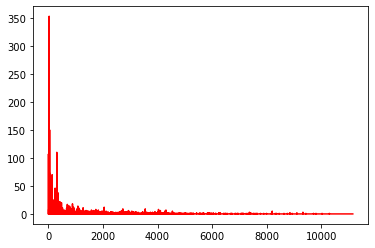

In [301]:
print('Number of components', len(components), 'Total number of ingredients', len(model.wv.vocab))

total_count = 0
for component in components:
    total_count += len(component)
    

plt.plot(list(range(len(components))), list(map(len, components)), 'r')

In [308]:
# mapping ingredients to the most common ingredient in their component
mapper = {}
for component in components:
    max_occurrence = 0
    most_occurring = ""
    for ingredient in component:
        occurrence = vocab_count[ingredient]
        if occurrence > max_occurrence:
            max_occurrence = occurence
            most_occurring = ingredient
    for ingredient in component:
        mapper[ingredient] = most_occurring


vanillaicecream grahamcrackercrust vanillaicecream
Frenchvanillaicecream grahamcrackercrust vanillaicecream
low-fatvanillaicecream grahamcrackercrust vanillaicecream
lightvanillaicecream grahamcrackercrust vanillaicecream
reduced-fatvanillaicecream grahamcrackercrust vanillaicecream
nonfatvanillaicecream grahamcrackercrust vanillaicecream
fatfreevanillaicecream grahamcrackercrust vanillaicecream
sugar-freevanillaicecream grahamcrackercrust vanillaicecream
instantvanillapudding grahamcrackercrust vanillaicecream
instantbananapuddingmix grahamcrackercrust vanillaicecream
bananapuddingmix grahamcrackercrust vanillaicecream
instantcoconutpuddingmix grahamcrackercrust vanillaicecream
instantbutterpecanpuddingmix grahamcrackercrust vanillaicecream
sugar-freeinstantbananapuddingmix grahamcrackercrust vanillaicecream
sugar-freeinstantbananacreampuddingmix grahamcrackercrust vanillaicecream
fat-freesugar-freeinstantvanillapuddingmix grahamcrackercrust vanillaicecream
fat-freeinstantvanillapuddi

In [304]:
# transform ingredients in recipe list
for i in range(len(ingredient_list)):
    new_ingredients = []
    for ingredient in ingredient_list[i]:
        new_ingredients.append(mapper[ingredient])
    ingredient_list[i] = new_ingredients

In [317]:
# save new recipe list
with open('../dataset/layers/layer4.json', 'w') as layer4file:
    layer4file.write(json.dumps(ingredient_list[::10], indent=4))